In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
# from tools_lnd import get_T_inds, plot_FP, plot_N, plot_N3D, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
# from tools_lnd import make_lil_axes, same_stim_trial, generate_Beta_epoch, gen_X_from_model_dir_epoch, make_D_use
# from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir
from tools_lnd import same_mov_inds, get_interp_filename
from tools_lnd import bifurc, plot_bifurc_ends, take_names, gen_mov_trial_set, make_D_use, gen_trials_from_model_dir

In [2]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'mem_motifs_small'
rule_trains = rules_dict[ruleset]
n_tasks = str(len(rule_trains))
rule_trains_str = '_'.join(rule_trains)
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '0'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# net_name = 'lr7.0l2_w6.0_h-0.0_fdgo_fdanti'
data_folder = 'data/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [3]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v5_figs','paper_figs','fig2','fig2_two_task_bifurc')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [4]:
# model = Model(m)
# with tf.Session() as sess:
#     model.restore()
#     model._sigma=0
#     var_list = model.var_list
#     params = [sess.run(var) for var in var_list]
#     hparams = model.hp
#     trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
#     feed_dict = tools.gen_feed_dict(model, trial, hparams)
#     h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
#     n_input = hparams['n_input']
#     n_rnn = hparams['n_rnn']
#     n_output = hparams['n_output']
#     w_in = params[0]
#     b_in = params[1]
#     w_out = params[2]
#     b_out = params[3]
#     sigma_rec = 0#hparams['sigma_rec']
#     dt = hparams['dt']
#     tau = hparams['tau']
#     alpha = dt/tau
#     activation = hparams['activation']


In [4]:
q_thresh = 1e-8
offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]
rule_axs = 0
rule_set = [5,2]
trial_set = gen_mov_trial_set(m,rule_set)
epoch_set = ['fix1','fix1']
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]

rule1 = rules_dict['all'][rule_set[0]]
rule2 = rules_dict['all'][rule_set[1]]
rule_str = [rule1,rule2]

ax_labels = 'pca_h'
D_fix = make_D_use(m,rule,'fix1',ti,ax_labels)
D_use = D_fix

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0'

In [5]:
interp = True
fig_size = 6

epoch_set = ['fix1','fix1']
script_name = 'interp_tasks_small_init_stim'

ax_use = [0,1,2]
D_rotate = D_use[:,ax_use]
ax_labels = [ax_labels_master[alm] for alm in ax_use]

ax_labels[2] = ax_labels_master[1] 
ax_labels[1] = ax_labels_master[0] 
ax_labels[0] = r"Rule Input $\alpha$"

# bifurc(m,D_rotate,rule_set,epoch_set,script_name = script_name,q_thresh = q_thresh, rule_axs = rule_axs, 
#        color_stim = True, fig_size = fig_size,fontsize = 16, figpath = figpath, ruleset = ruleset,
#        ax_labels = ax_labels, stability_thresh = 1.05, lims = [])

# plot_bifurc_ends(m, D_rotate, rule_set, epoch_set, script_name, lims = [], fac_mult_lims = 2,
#                  stability_thresh = 1.05, fp_first = False, figpath = figpath, ruleset = ruleset,
#                 ax_labels = [ax_labels[0],ax_labels[1]])

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

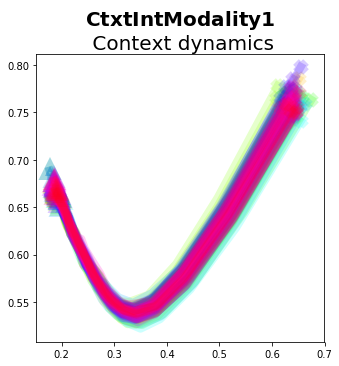

delaygo
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' 

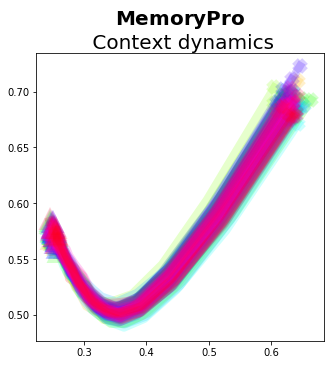

In [159]:
from tools_lnd import same_stim_trial,load_fps_from_interp,plot_FPs,gen_X_from_model_dir, plot_N, get_T_inds
ax_labels = [ax_labels_master[alm] for alm in ax_use]

ax_labels[2] = ax_labels_master[1] 
ax_labels[1] = ax_labels_master[0] 
ax_labels[0] = r"Rule Input $\alpha$"

stability_thresh = 1.05
fp_first = False
ax_labels = [ax_labels[0],ax_labels[1]]
D_use = D_rotate
tol_q = 1e-6
t_set = [0,0]
q_thresh = .0000001
fig_size = 4
lims = []
fac_mult_lims = 2
# stability_thresh = 1
color_stim = True
step_set = [0,19]
figpath = 'plot_bifurc_ends'
ruleset = 'all'
fontsize = 20
plot_unstable = True
plot_expansion = False
ax_labels = []
rule_set = [8,2]

cmap_discrete = ['w','k']
cmap_grad = plt.get_cmap('plasma')

rule1 = rules_dict['all'][rule_set[0]]
rule2 = rules_dict['all'][rule_set[1]]
rule_str = [rule1,rule2]

if color_stim:
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, rule_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
else:
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
    trial2 = same_mov_inds(trial1, trial2) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

# save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
# filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

yup = {}
for ri in [0,1]:
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    ax = fig.add_axes([0,0,1,1])

#     sorted_fps, eig_decomps = load_fps_from_interp(m,script_name,rule_str,tol_q,filename_interp,
#                                                      step_set[ri],q_thresh)

#     if fp_first:
#         plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
#             stability_thresh = stability_thresh, plot_unstable = plot_unstable,
#             plot_expansion = plot_expansion)

    rule = rule_str[ri]
    epoch = epoch_set[ri]
    c_master = cmap_discrete[ri]

    print(rule)
    trial = gen_trials_from_model_dir(m,rule,mode='random',noise_on = False,batch_size = 100)
    trial_inds = range(0,np.shape(trial.x)[1]) 
    yup[rule] = trial

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[ri])
    T_inds_plot = range(np.max([T_inds[0]-1,0]),T_inds[-1])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

    c_set = np.linspace(0,1,100)

    lw = 10
    plot_N(x_epoch[trial_inds,:,:], D_use.T, c_set[trial_inds], linewidth = fig_size*2, alpha = .2)

#     if not fp_first:
#         plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
#             stability_thresh = stability_thresh, plot_unstable = plot_unstable,
#             plot_expansion = plot_expansion)

    epoch_name, rule_name, _, _ = take_names(epoch_set[ri],rule_str[ri])

    if len(ax_labels)>0:
        make_lil_axes(ax,ax_labels)

    tit = r"$\bf{"+rule_name+"}$"+'\n '+epoch_name+' dynamics'
    tit_name = rule_name+'_'+epoch_name+'_dynamics'
    plt.title(tit,fontsize = fontsize)#,y = .9
#     fig_fldr = os.path.join(figpath,'interp_fps',ruleset,'bifurcation')
#     if not os.path.exists(fig_fldr):
#         os.makedirs(fig_fldr)

#     plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
#     plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
    plt.show()

In [150]:
rule1 = 'delaygo'
rule2 = 'delaydm1'

model = Model(m)
with tf.Session() as sess:

    model.restore()

    # model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    hparams = model.hp
    trial1 = generate_trials(rule1, hparams, mode='random',noise_on = False,batch_size = 100)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_rule1, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    
    trial2 = generate_trials(rule2, hparams, mode='random',noise_on = False,batch_size = 100)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_rule2, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt


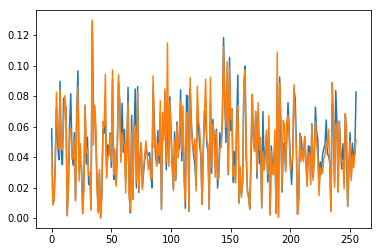

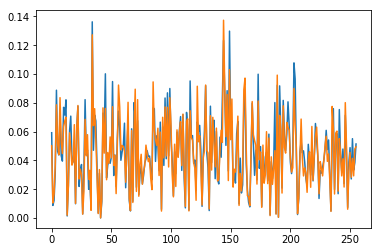

In [151]:
plt.plot(h_rule1[1,2,:])
plt.plot(h_rule2[1,2,:])
plt.show()

plt.plot(h_rule1[1,1,:])
plt.plot(h_rule2[1,1,:])
plt.show()

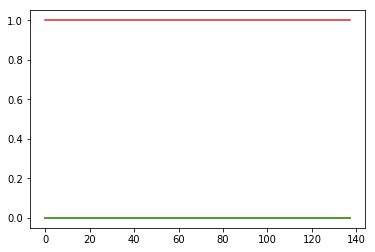

In [92]:
plt.plot(yup['delayanti'].x[:,1,7:11])
plt.show()